I use this exercise as an opportunity to revise the concepts of pytorch. So before using the modules and classes such as `torch.nn`, `torch.optim`, `Dataset`, `DataLoader` to create and train a neural network, I will build a simple network from scratch and then replace each component with the functionality provided by the mentioned modules, gradually. For this, I am using the tutorial provided in the pytorch documentation here: https://pytorch.org/tutorials/beginner/nn_tutorial.html

### Dataset setup

I use the MNIST dataset, which consist of images of digits (between 0 to 9)

In [1]:
from pathlib import Path
import requests

# setup the path to store the data
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

# create the directory 
PATH.mkdir(parents = True, exist_ok = True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

# if file not exist, download
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

The data is stored in numpy arrays and pickled. The following block of code will read the file and store it in a varaible.

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [3]:
print(x_train.shape)

(50000, 784)


x_train contains 50,000 samples. each sample is a vector of length 784.

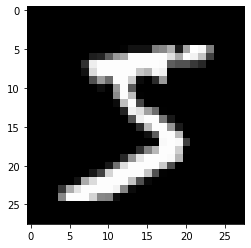

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0]. reshape((28,28)), cmap = 'gray')

pytorch is a replacement to numpy to use the power of a gpu. It uses `torch.tensor` instead of `numpy.array`. So we will convert the data into tensor format.

In [5]:
import torch

# map numpy array to torch.tensor
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
# shape of training data
n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### NN from scratch

First, we create two tensors for weights and bias. The argument requires_grad = True causes pytorch to record all the oprations doen on the tensor so that it can calculate the gradient during backprop automatically.

In [6]:
import math
# similar to numpy, generates 2D tensor
weights = torch.randn(784,10)/ math.sqrt(784)
# set requires gradient true
weights.requires_grad_()
# we set requires gradient true while creating the tensor
bias = torch.zeros(10, requires_grad = True)

Next, we define our model and activation function. pytorch provides modules for this which will be used later.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# 1 layer network with log_softmax activation
def model(xb):
    return log_softmax(xb @ weights + bias)

In [8]:
# batch size
bs = 64 

# example of an forward pass
# minibatch from train set
xb = x_train[0:bs]
# apply our function to batch
preds = model(xb)

print(preds[0], preds.shape)

tensor([-2.4306, -2.3667, -1.5934, -2.4719, -2.8305, -2.6258, -2.7941, -2.0013,
        -2.2031, -2.3814], grad_fn=<SelectBackward>) torch.Size([64, 10])


As we can see, the output is a vector of length 10. Currently, the model is not trained (randomly intialized weights and bias), hence, the output is a gibberish. 

We will use neagtive log-liklihood as a loss function. 

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Now, let's check the loss of our model on a minibatch.

In [10]:
# true value
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4351, grad_fn=<NegBackward>)


Accuracy: if a index with the largest value in the output vector matches the target value, the the prediction is correct.

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0625)


### training

Process:
    for each iteration
    - select a mini-batch of data
    - use model to make predictions
    - calculate the loss
    - `loss.backward()` updates the gradient of the model (weights and bias)
   
`loss.backward()` adds the gradient to whatever is already stored. So after each batch, we manually set the gradient to zero before the next loop. 

In [12]:
# learning rate
lr = 0.5

epochs = 2 # number of pass through data

for epoch in range(epochs):
    # for each batch (total 782 batches size 64)
    for i in range ((n-1)//bs+1):
        # batch start and end index
        start_i = i*bs
        end_i = start_i +bs
        # current batch
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        # make prediction
        pred = model(xb)
        # compute loss
        loss = loss_func(pred, yb)
        
        # compute gradient
        loss.backward()
        
        # update params and set the gradient to zero
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

That's all. We have created a minimal neural network (actually logistic regression as there is only 1 layer). 
Next, let's compare the loss before and after training. We expect the loss to decrease.

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0836, grad_fn=<NegBackward>) tensor(1.)


### use torch modules and library for more cleaner and concise code

#### nn.functional

We can replace our hand written activation and loss function with those from the nn.functional module. This module contains wide variety of loss and activation functions.

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

#### nn.Module

We subclass nn.Module to create a class that holds weights, bias, and a method for forward pass. nn.Module provides a number of attributes and methods useful for downstream tasks.

In [15]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self,xb):
        return xb @ self.weights + self.bias

We instantiate the object of our class. The object is callable and executes forward method when called. 

In [16]:
model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.3992, grad_fn=<NllLossBackward>)


Previously, we had to update the parameters manually. Now we use `model.parameters()` and `model.zero_grad()` to make those step concise. Also we add the training code inside a fit method.

In [17]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)// bs+1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad*lr
                model.zero_grad()

fit()

In [18]:
# check that our loss has gone down
print(loss_func(model(xb), yb))

tensor(0.0845, grad_fn=<NllLossBackward>)


Next, rather than defining our parameters and network manually, we will use nn.Linear class, which do that for us. pytorch has many predefined layers to simplify the construction of a neural network.

In [19]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [20]:
# instantiate the model and claculate the loss as before
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3474, grad_fn=<NllLossBackward>)


In [21]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


#### torch.optim

In our training loop, we manually coded the optimization step, updating one parameter at a time inside the loop. `torch.optim` provides various optimization algorithms such Adam, SGD, etc. We can use .step() method  to update parameters.

In [22]:
from torch import optim 

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

# also put model and optimizer in a function
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
fit()
print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward>)


#### Dataset and DataLoader

By defining a length and way of indexing, TensorDataset class gives us a way to iterate, index, and slice along the firat dimension of a tensor. This will make it easy to access dependent and independent varaibles in the same line as we train. 

In [23]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

# now we can iterate through minibatches in a single line
# xb, yb = train_ds[i*bs : i*bs +bs]

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


DataLoader manages batches. We crate DataLoader from any Dataset. DataLoader gives us a minibatch automatically, rather than us having to slices the dataset manually.

In [24]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)

# data loader
train_dl = DataLoader(train_ds, batch_size = bs)

# our codes upadate to this
model, opt = get_model()

for epoch in range(epochs):
    # we iterate over batches rather than indexing and slicing
    for xb, yb in train_dl: 
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


We will now add validation set and assess the performance.

In [25]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print("epoch:", epoch, "loss:" , valid_loss / len(valid_dl))

epoch: 0 loss: tensor(0.3171)
epoch: 1 loss: tensor(0.2877)


We will do some more refactoring for readability of the code. Since we are calculating loss for both training and validation set, we will create a new function loss_batch that computes a loss for one batch. If optimizer is passed, it performs backprop.

In [26]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

fit perform the training and reports the validation loss.

In [27]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print("epoch:", epoch, "loss:" , valid_loss / len(valid_dl))

get_data returns the dataloader for training and validation.

In [28]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now we can specify the entire process in 3 lines of code

In [29]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0 loss: tensor(0.2877)
epoch: 1 loss: tensor(0.2877)


### Create more advanced NN (CNN)

Now to demonstrate the usage of code, we will create CNN to classify digits using our dataset.

In [30]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0 loss: tensor(0.2877)
epoch: 1 loss: tensor(0.2877)


#### nn.Sequential

Sequential module provides a handy way to create a model. Sequencial object runs each of the modules contained within it in a sequencial manner. We can create a custom layer from a function and use it when defining the network with sequencial.

In [31]:
# define a custome layer
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

# define a model with Sequential
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


epoch: 0 loss: tensor(0.2877)
epoch: 1 loss: tensor(0.2877)


#### GPU!

Finally we can use GPU to train faster and use .to(dev) method to send tensor to GPU.

In [32]:
# create the device object
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In the above code, we use preprocessing layer within our network. Rather, we can write a wrapper to the dataloader to do the preprocessing. Thia way we can abstarct our model to use with different shape of datasets.

In [33]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


epoch: 0 loss: tensor(0.2877)
epoch: 1 loss: tensor(0.2877)


The code shown is the final code that we need to create and train neural network.

#### stochastic_gradient_descent_example from class.

In [34]:
# training data (plotted at the end of this file)
train = np.array([[-2,-10], [-1,-5], [0, 0], [1,5], [2,10]])
x_train = torch.Tensor(train[:, 0])
y_train = torch.Tensor(train[:, 1])

In [35]:
# for stochastic gradient descent, create batches
batch_size = 1

# dataset and dataloader
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [36]:
import numpy as np

# fit method for training

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl):
    for epoch in range(epochs):
        # train the model
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        # evaluate on the train set
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print("epoch:", epoch, "loss:" , valid_loss / len(valid_dl))

In [37]:
# create model
model = nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, 1)   
)

alpha = 0.001
opt = optim.SGD(model.parameters(), lr=alpha)
loss_func = nn.MSELoss()
epochs = 40

# fit the model
fit(epochs, model, loss_func, opt, train_dl)

epoch: 0 loss: tensor(0.2877)
epoch: 1 loss: tensor(0.2877)
epoch: 2 loss: tensor(0.2877)
epoch: 3 loss: tensor(0.2877)
epoch: 4 loss: tensor(0.2877)
epoch: 5 loss: tensor(0.2877)
epoch: 6 loss: tensor(0.2877)
epoch: 7 loss: tensor(0.2877)
epoch: 8 loss: tensor(0.2877)
epoch: 9 loss: tensor(0.2877)
epoch: 10 loss: tensor(0.2877)
epoch: 11 loss: tensor(0.2877)
epoch: 12 loss: tensor(0.2877)
epoch: 13 loss: tensor(0.2877)
epoch: 14 loss: tensor(0.2877)
epoch: 15 loss: tensor(0.2877)
epoch: 16 loss: tensor(0.2877)
epoch: 17 loss: tensor(0.2877)
epoch: 18 loss: tensor(0.2877)
epoch: 19 loss: tensor(0.2877)
epoch: 20 loss: tensor(0.2877)
epoch: 21 loss: tensor(0.2877)
epoch: 22 loss: tensor(0.2877)
epoch: 23 loss: tensor(0.2877)
epoch: 24 loss: tensor(0.2877)
epoch: 25 loss: tensor(0.2877)
epoch: 26 loss: tensor(0.2877)
epoch: 27 loss: tensor(0.2877)
epoch: 28 loss: tensor(0.2877)
epoch: 29 loss: tensor(0.2877)
epoch: 30 loss: tensor(0.2877)
epoch: 31 loss: tensor(0.2877)
epoch: 32 loss: te

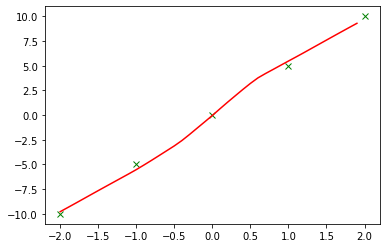

In [38]:
# test the model
D=np.arange(-2,2,.1).reshape((40,1))
R=model(torch.Tensor(D)).detach().numpy()

from matplotlib import pyplot as plt
plt.plot(x_train,y_train,'gx',D,R,'r-')